# FX Leverage Carry-Trade

Groupname: Blue Horseshoe

### Background
The project seeks to implement the well-known carry trade in Forex markets, which involves borrowing money in a low-yielding currency and investing it for a given period of time in a high-yielding currency. In our case, we consider ourselves as investors possessing JPY, and investing this in currencies including the GBP, AUD and USD. Since currency markets can be volatile, signals usually don't last for more than 2 or 3 months at a stretch - hence, we focus our efforts on rebalancing at tenors (time periods) of 1 week, 1 month and 2 months. We note that forward data for the AUDJPY for 1 week was not available, so this criteria was omitted from our analysis.

### Goals
The two sets of decisions as investors that we have to make would be the choice of currency, as well as the duration of the investment. 

### Methods & Features
We tackle both decision by the use of the interest rate parity signal, which is 

$\frac{F(1 + r_f)}{S} - (1 + r_d)$ 

where F is the forward rate, S the spot rate and $r_f$ and $r_d$ the foreign and domestic currencies respectively (note the values of spot and forward rates are computed as CCYJPY, with CCY being the foreign currency). 

As $r_f$ varies across foreign currency and time periods, and $r_d$ solely across time periods, we determine the currency and time period that generates the highest possible signal to invest in. Once this is decided, we 1) convert the JPY into the currency 2) invest in the existing LIBOR/risk-free rate of the currency 3) convert the currency back into JPY at the prevailing rates at the end of the cycle 4) Repeat the process by determining the best signals.

In case none of the signals are positive, we choose to invest our equity overnight in an money-market fund offering a 0 % interest rate. The reason for this is that interest rates have been historically low in Japan (< 1%), with rates becoming negative since 2016. Our only alternative is to invest at the JPY LIBOR, which offers potentially negative interest rates. Most money managers and banks offer overnight rates at a slightly higher rate than the JPY LIBOR, which we assume to be 0 %. Furthermore, since we only consider a minimum tenor of 1 week, keeping our equity locked up over this period could potentially lead to us missing a 'good' signal. 

Another important feature of our strategy is the use of leverage. Most carry trades involve leverage, since the FX markets can often have long spells (regimes) of sideways movement with minimal returns. Leverage serves to amplify these returns, but can also contribute to magnified losses which could potentially wipe out the entire equity leading to bankruptcy. 

### Transaction Cost

We also consider the effects of transaction cost. One of the biggest source is from bid-ask spread of Forex. Such transaction costs are inevitable since the spread is determined by Forex market maker. One of the way to minimize the spread is implementing the trade when spread is narrow, however, this may lead to the opportunity cost. After trade-off, we decided to directly take the spread into account, that is, we buy the FX at ask price and sell them at bid price. Then, the formula for PNL is 

$ L * ((1 + r_f) * ((f_{\mbox{bid}} - f_{\mbox{ask}}) / f_{\mbox{ask}}) + r_f - r_d) + r_d $

The final result of our strategies show that we are still able to make profit even after considering the spread.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import carry_trade as ct
import datetime as dt

from date_function_v2 import holiday_adjust

matplotlib.rcParams['figure.figsize'] = (16, 9)
font = {'family': 'normal',
        'size': 20}

matplotlib.rc('font', **font)

## 1. Load data

In [2]:
data_path_new = 'Data/to_send.csv'
final_data_new = pd.read_csv(data_path_new)

In [3]:
final_data_new = final_data_new.set_index('Date')
final_data_new.index = pd.to_datetime(final_data_new.index)

In [4]:
#final_data_new.iloc[324:]

## 2. Implement Strategy 

We implement the strategy for two broad scenarios, pre- and post-crisis. The pre-crisis scenario involves trading from September 2007 onwards, while the post-crisis scenario avoids some of the major volatility spikes and fluctuations observed in 2008 and invests from 2009 onwards. The scenarios assume a fairly conservative leverage ratio of 2.

In [5]:
# if you want to test single currency or single trading period, just modify the following list
fx_list = ['USD', 'AUD', 'GBP']
period_list = [7, 30, 60]

In [7]:
results_pre_crisis = ct.algo_loop(final_data_new, fx_list, period_list, leverage = 2.0) # pre-crisis scenario 
results_post_crisis = ct.algo_loop(final_data_new.iloc[324:], fx_list, period_list, leverage = 2.0)

2019-12-07 18:15:57:307511: Beginning Carry-Trade Strategy run
2019-12-07 18:16:22:201783: Algo run complete.
2019-12-07 18:16:22:201783: Beginning Carry-Trade Strategy run
2019-12-07 18:16:42:961702: Algo run complete.


In [8]:
results_pre_crisis.to_csv('Results/results_pre_crisis.csv')
results_post_crisis.to_csv('Results/results_post_crisis.csv')

In [8]:
results_post_crisis

,Signal,FX_name,Period,Foreign_IR,Domestic_IR,FX_Rate,Equity,Asset Pos,Unreal_Return,Real_Return,Drawdown
Date,,,,,,,,,,,
2009-01-02,0.000484649,GBP,2M,0.02505,0.0075625,133.563,10000,20000,0.0014587,0,0
2009-01-05,0.000484649,GBP,2M,0.02445,0.0073875,137.348,10000,20000,0.0591682,0,0
2009-01-06,0.000484649,GBP,2M,0.0240875,0.0071875,139.69,10000,20000,0.0946591,0,0
2009-01-07,0.000484649,GBP,2M,0.023675,0.007075,139.85,10000,20000,0.096636,0,0
2009-01-08,0.000484649,GBP,2M,0.0230375,0.0069375,138.773,10000,20000,0.0805256,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-11-05,5.13588e-05,AUD,2M,0.0092,-0.000965,75.247,16811.8,33623.7,0.0857553,0.681185,-0.301316
2019-11-06,5.13588e-05,AUD,2M,0.0093,-0.000935,75.024,16811.8,33623.7,0.0795475,0.681185,-0.301316
2019-11-07,5.13588e-05,AUD,2M,0.009183,-0.0010383,75.385,16811.8,33623.7,0.0895318,0.681185,-0.301316


In [13]:
print('Cumulative Return in the post-crisis scenario:', results_post_crisis['Real_Return'][-1]*100,'%')
print('Cumulative Return in the pre-crisis scenario:', results_pre_crisis['Real_Return'][-1]*100,'%')
print('Max Drawdown between trades in the post-crisis scenario:', results_post_crisis['Drawdown'].min()*100,'%')
print('Max Drawdown between trades in the pre-crisis scenario:', results_pre_crisis['Drawdown'].min()*100,'%')

Cumulative Return in the post-crisis scenario: 68.1184855228 %
Cumulative Return in the pre-crisis scenario: -35.8594756138 %
Max Drawdown between trades in the post-crisis scenario: -38.3190478784 %
Max Drawdown between trades in the pre-crisis scenario: -72.4711311443 %


In [14]:
# if you want to test single currency or single trading period, just modify the following list
usd_list = ['USD']
aud_list = ['AUD']
gbp_list = ['GBP']

In [15]:
results_usd = ct.algo_loop(final_data_new.iloc[324:], usd_list, period_list, leverage = 2.0)
results_aud = ct.algo_loop(final_data_new.iloc[324:], aud_list, period_list, leverage = 2.0)
results_gbp = ct.algo_loop(final_data_new.iloc[324:], gbp_list, period_list, leverage = 2.0)

2019-12-07 18:18:11:693960: Beginning Carry-Trade Strategy run
2019-12-07 18:18:27:579518: Algo run complete.
2019-12-07 18:18:27:580515: Beginning Carry-Trade Strategy run
2019-12-07 18:18:38:021844: Algo run complete.
2019-12-07 18:18:38:021844: Beginning Carry-Trade Strategy run
2019-12-07 18:18:50:852830: Algo run complete.


In [16]:
print('Cumulative Return, USD only:', results_usd['Real_Return'][-1]*100,'%')

Cumulative Return, USD only: 1.53327693492 %


In [17]:
print('Cumulative Return, AUD only:', results_aud['Real_Return'][-1]*100,'%')

Cumulative Return, AUD only: 38.8364733903 %


In [18]:
print('Cumulative Return, GBP only:', results_gbp['Real_Return'][-1]*100,'%')

Cumulative Return, GBP only: 32.343472269 %


## 3. Analysis 

## 3.1 After Crisis


### 3.1.1 Realized Return Time Series

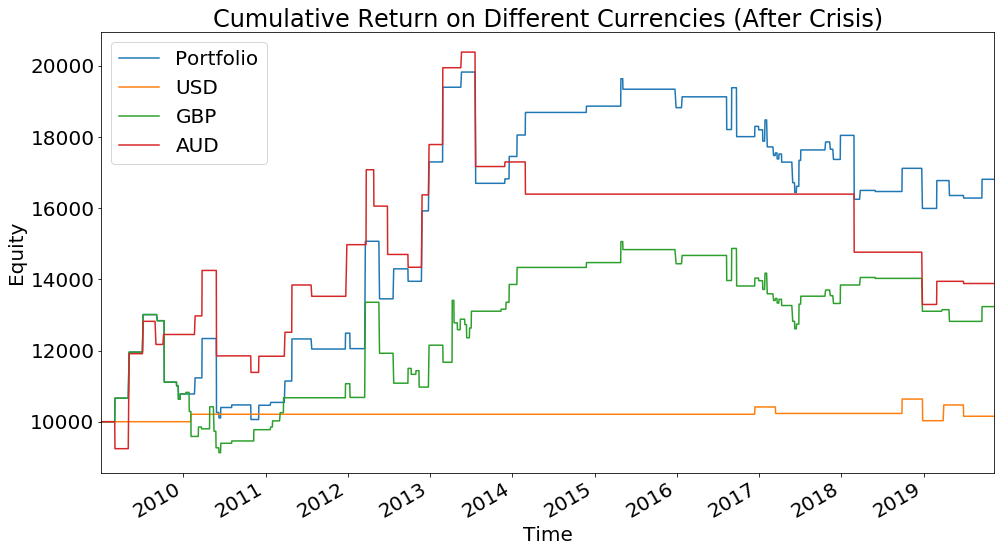

In [37]:
results_post_crisis['Equity'].plot(label='Portfolio')
results_usd['Equity'].plot(label='USD')
results_gbp['Equity'].plot(label='GBP')
results_aud['Equity'].plot(label='AUD')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Equity')
plt.title('Cumulative Return on Different Currencies (After Crisis)')
plt.show()

As you can see, the diversified portfolio tends to outperform but closely track the AUD portfolio, which makes sense due to the high spread between the Japanese and Australian interest rates

### 3.1.2 Realized Return Histogram

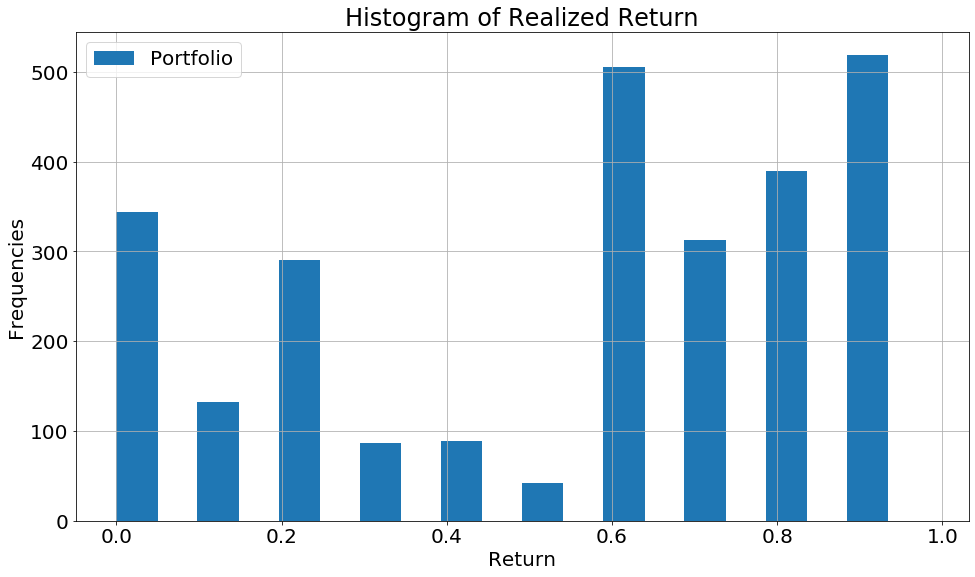

In [38]:
results_post_crisis['Real_Return'].hist(width=0.05, label='Portfolio')
plt.legend()
plt.xlabel('Return')
plt.ylabel('Frequencies')
plt.title('Histogram of Realized Return')
plt.show()

EXPLAIN WHY IT IS SO

### 3.1.3 Unrealized Return Histogram

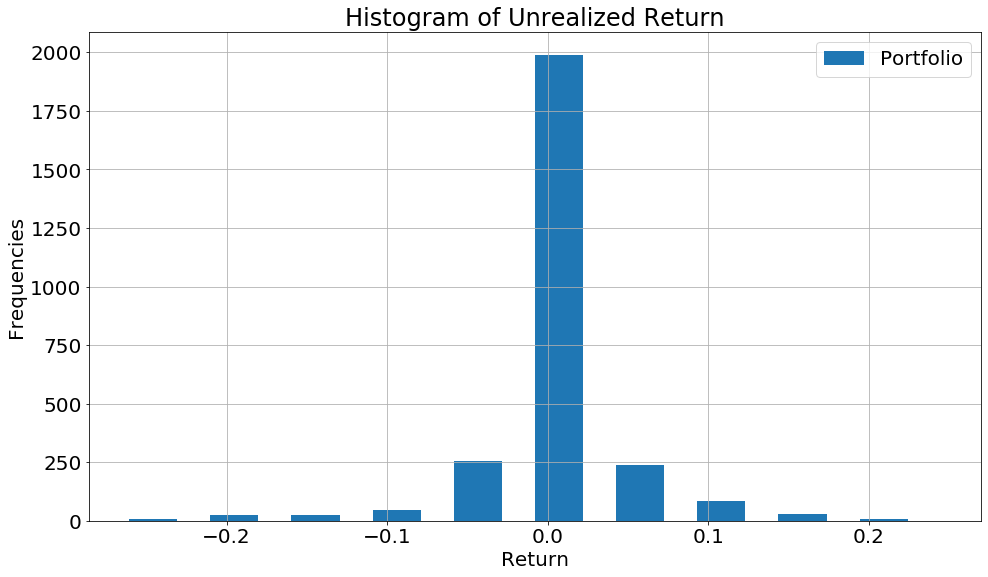

In [39]:
results_post_crisis['Unreal_Return'].hist(width=0.03, label='Portfolio')
plt.legend()
plt.xlabel('Return')
plt.ylabel('Frequencies')
plt.title('Histogram of Unrealized Return')
plt.show()

EXPLAIN WHY IT IS SO

### 3.1.4 Value at Risk

The Value at Risk, or VaR, is an estimate of how much the portfolio can lose over a given time period (one day in our case) at a certain confidence level.  For example, a VaR of 10 % at a 95 % confidence level would mean that we are 95 % certain (or that 95 times out of a 100) that a portfolio could sustain losses of no more than 10 % during that day. The higher the confidence level, the greater the loss estimate and hence the greater the VaR. There is both a parameteric method as well as a historical method of computing VaR - we use the historical method since we have a sufficient number of data points for a fairly accurate estimation. The methodology involves
* sorting returns from smallest to largest
* choosing the quantile of returns that corresponds to (1 - confidence level)

In [22]:
return_post_crisis = results_post_crisis['Unreal_Return'].sort_values()
print('VaR at 90% confidence level:', return_post_crisis.quantile(0.1)*-1*100,'%')
print('VaR at 95% confidence level:', return_post_crisis.quantile(0.05)*-1*100,'%')
print('VaR at 99% confidence level:', return_post_crisis.quantile(0.01)*-1*100,'%')

VaR at 90% confidence level: 1.79248099824 %
VaR at 95% confidence level: 4.62553855463 %
VaR at 99% confidence level: 16.2634905273 %


### 3.1.5 Sharpe Ratio and Volatility

We measure the daily and annualized sharpe ratios using our unrealized returns. Our opportunity cost $r_f$ is assumed to be 0, hence the formula for Sharpe ratio is given by $\frac{\mu} {\sigma}$ , where $\mu$ and $\sigma$ are the mean and standard deviation of the unrealized returns respectively.

In [32]:
sharpe_post_crisis =  results_post_crisis['Unreal_Return'].mean()/results_post_crisis['Unreal_Return'].std()
print('Daily Sharpe Ratio:', sharpe_post_crisis)
print('Annual Sharpe Ratio:', sharpe_post_crisis * np.sqrt(251))

Daily Sharpe Ratio: 0.158239491021
Annual Sharpe Ratio: 2.50698501514


In [33]:
volatility_post_crisis = results_post_crisis['Real_Return'].std()
print('Volatility, after crisis:', volatility_post_crisis*100,'%')

Volatility, after crisis: 31.5506671238 %


## 3.2 Before Crisis vs. After Crisis

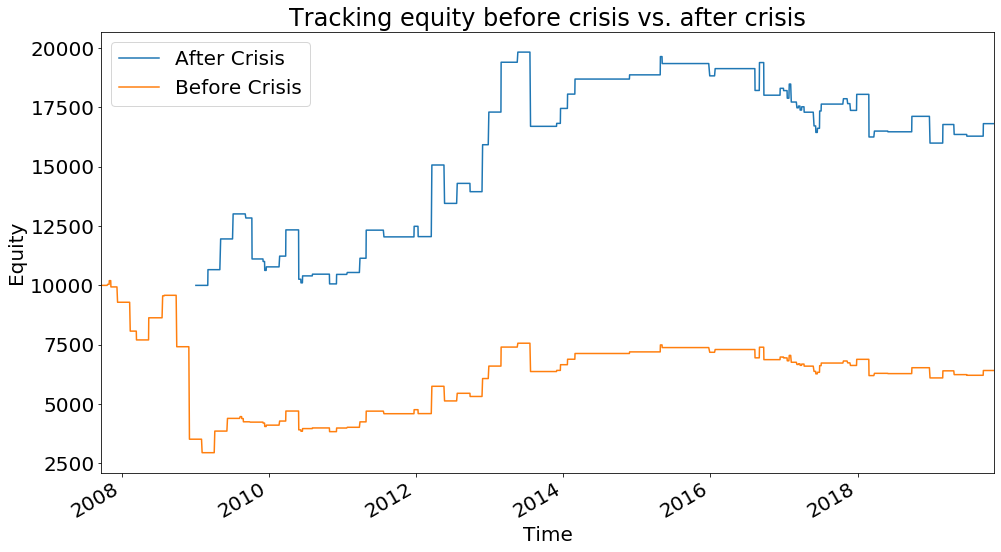

In [40]:
results_post_crisis['Equity'].plot(label='After Crisis')
results_pre_crisis['Equity'].plot(label='Before Crisis')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Equity')
plt.title('Tracking equity before crisis vs. after crisis')
plt.show()

### 3.2.1 Value at Risk

In [23]:
return_post_crisis = results_post_crisis['Unreal_Return'].sort_values()
print('VaR at 90%, after crisis:', return_post_crisis.quantile(0.1)*-1*100,'%')
print('VaR at 95%, after crisis:', return_post_crisis.quantile(0.05)*-1*100,'%')
print('VaR at 99%, after crisis:', return_post_crisis.quantile(0.01)*-1*100,'%')

VaR at 90%, after crisis: 1.79248099824 %
VaR at 95%, after crisis: 4.62553855463 %
VaR at 99%, after crisis: 16.2634905273 %


In [24]:
return_pre_crisis = results_pre_crisis['Unreal_Return'].sort_values()
print('VaR at 90%, before crisis:', return_pre_crisis.quantile(0.1)*-1*100,'%')
print('VaR at 95%, before crisis:', return_pre_crisis.quantile(0.05)*-1*100,'%')
print('VaR at 99%, before crisis:', return_pre_crisis.quantile(0.01)*-1*100,'%')

VaR at 90%, before crisis: 3.720340479 %
VaR at 95%, before crisis: 9.56858025076 %
VaR at 99%, before crisis: 23.5242714278 %


### 3.2.2 Sharpe Ratio and Volatility

In [41]:
sharpe_pre_crisis =  results_pre_crisis['Unreal_Return'].mean()/results_pre_crisis['Unreal_Return'].std()
print('Daily Sharpe Ratio after crisis:', sharpe_post_crisis)
print('Annual Sharpe Ratio after crisis:', sharpe_post_crisis * np.sqrt(251))
print('Daily Sharpe Ratio before crisis:', sharpe_pre_crisis)
print('Annual Sharpe Ratio before crisis:', sharpe_pre_crisis * np.sqrt(251))

Daily Sharpe Ratio after crisis: 0.158239491021
Annual Sharpe Ratio after crisis: 2.50698501514
Daily Sharpe Ratio before crisis: 0.0118466228733
Annual Sharpe Ratio before crisis: 0.187685803537


In [42]:
volatility_pre_crisis = results_pre_crisis['Real_Return'].std()
print('Volatility after crisis:', volatility_post_crisis*100,'%')
print('Volatility before crisis:', volatility_pre_crisis*100,'%')

Volatility after crisis: 31.5506671238 %
Volatility before crisis: 15.1602213327 %


EXPLAIN WHY IT IS SO

## 3.3 Leverage Analysis

In this section, we explore the effect of leverage on our portfolio. As most carry trades assume some leverage to realize meaningful returns, we use a conservative leverage of 2 for most of our project. We now explore how modifying leverage can affect our returns both pre, and post crisis. 

The formula for returns (on equity) in the carry trade with leverage is given by $L[(1+q)\frac{\delta S}{S} + q - r] + r$, where $L$ is the leverage, $q$ is the foreign interest rate, $r$ is the domestic interest rate and $S$ is the spot rate (Malz, 2019). The leverage itself is defined as $\frac{Assets}{Equity}$, where $Assets = Equity + Debt$ is the total amount involved in the trade. Every trade in a scenario is assumed to have the same leverage, with the amount borrowed being $(Leverage - 1)*Equity$. We explore the pre and post-crisis scenarios independently to determine the influence the highly volatile FX market swings had on portfolios with varying leverages.

### 3.3.1 After Crisis

In [36]:
results_post_crisis_l3 = ct.algo_loop(final_data_new.iloc[324:], fx_list, period_list, leverage = 3.0)
results_post_crisis_l4 = ct.algo_loop(final_data_new.iloc[324:], fx_list, period_list, leverage = 4.0)
results_post_crisis_l5 = ct.algo_loop(final_data_new.iloc[324:], fx_list, period_list, leverage = 5.0)
results_post_crisis_l6 = ct.algo_loop(final_data_new.iloc[324:], fx_list, period_list, leverage = 6.0)

2019-12-06 17:16:47:149914: Beginning Carry-Trade Strategy run
2019-12-06 17:17:01:007987: Algo run complete.
2019-12-06 17:17:01:008455: Beginning Carry-Trade Strategy run
2019-12-06 17:17:14:952222: Algo run complete.
2019-12-06 17:17:14:952691: Beginning Carry-Trade Strategy run
2019-12-06 17:17:28:748623: Algo run complete.
2019-12-06 17:17:28:749143: Beginning Carry-Trade Strategy run
2019-12-06 17:17:42:865929: Algo run complete.


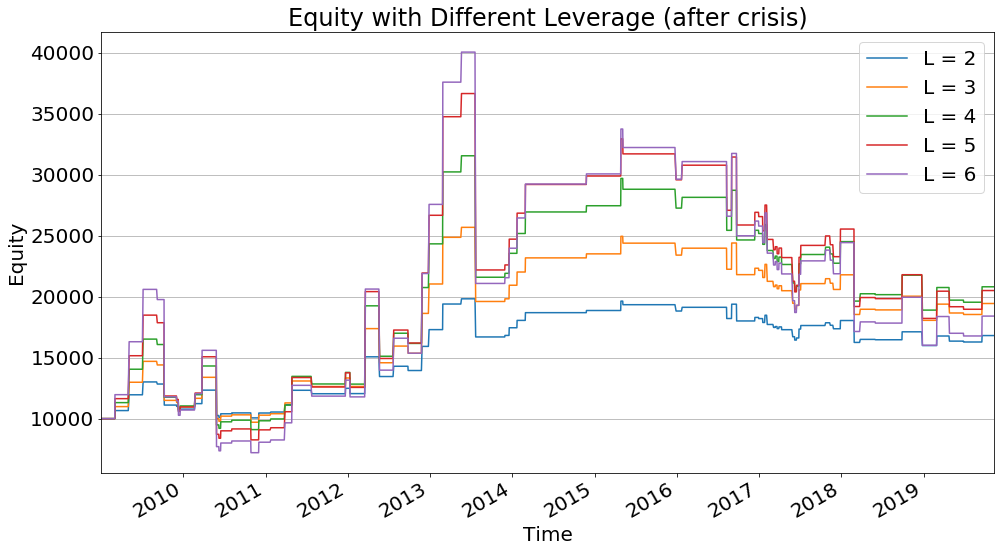

In [37]:
results_post_crisis['Equity'].plot(label='L = 2')
results_post_crisis_l3['Equity'].plot(label='L = 3')
results_post_crisis_l4['Equity'].plot(label='L = 4')
results_post_crisis_l5['Equity'].plot(label='L = 5')
results_post_crisis_l6['Equity'].plot(label='L = 6')
plt.grid(True, axis='y')
plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Equity')
plt.title('Equity with Different Leverage (after crisis)')
plt.savefig('Results/Real_Return_leverages_post_crisis.jpg')

EXPLAIN GRAPH

In [38]:
sharpe_post_crisis =  results_post_crisis['Unreal_Return'].mean()/results_post_crisis['Unreal_Return'].std()
sharpe_post_crisis_l3 =  results_post_crisis_l3['Unreal_Return'].mean()/results_post_crisis_l3['Unreal_Return'].std()
sharpe_post_crisis_l4 =  results_post_crisis_l4['Unreal_Return'].mean()/results_post_crisis_l4['Unreal_Return'].std()
sharpe_post_crisis_l5 =  results_post_crisis_l5['Unreal_Return'].mean()/results_post_crisis_l5['Unreal_Return'].std()
sharpe_post_crisis_l6 =  results_post_crisis_l6['Unreal_Return'].mean()/results_post_crisis_l6['Unreal_Return'].std()


print('Leverage = 2, annualized Sharpe Ratio:', sharpe_post_crisis * np.sqrt(251))
print('Leverage = 3, annualized Sharpe Ratio:', sharpe_post_crisis_l3 * np.sqrt(251))
print('Leverage = 4, annualized Sharpe Ratio:', sharpe_post_crisis_l4 * np.sqrt(251))
print('Leverage = 5, annualized Sharpe Ratio:', sharpe_post_crisis_l5 * np.sqrt(251))
print('Leverage = 6, annualized Sharpe Ratio:', sharpe_post_crisis_l6 * np.sqrt(251))


L2, Sharpe Ratio each year: 2.5069850151429405
L3, Sharpe Ratio each year: 2.4963635317613964
L4, Sharpe Ratio each year: 2.4910487631126403
L5, Sharpe Ratio each year: 2.4878586178373836
L6, Sharpe Ratio each year: 2.485731320338369


### 3.3.2 Before Crisis

In [39]:
results_pre_crisis_l3 = ct.algo_loop(final_data_new, fx_list, period_list, leverage = 3.0)
results_pre_crisis_l4 = ct.algo_loop(final_data_new, fx_list, period_list, leverage = 4.0)
results_pre_crisis_l5 = ct.algo_loop(final_data_new, fx_list, period_list, leverage = 5.0)
results_pre_crisis_l6 = ct.algo_loop(final_data_new, fx_list, period_list, leverage = 6.0)

2019-12-06 17:19:55:027753: Beginning Carry-Trade Strategy run
2019-12-06 17:20:10:439449: Algo run complete.
2019-12-06 17:20:10:439679: Beginning Carry-Trade Strategy run
2019-12-06 17:20:10:978828: Algo run complete.
2019-12-06 17:20:10:979062: Beginning Carry-Trade Strategy run
2019-12-06 17:20:11:507485: Algo run complete.
2019-12-06 17:20:11:507704: Beginning Carry-Trade Strategy run
2019-12-06 17:20:12:061904: Algo run complete.


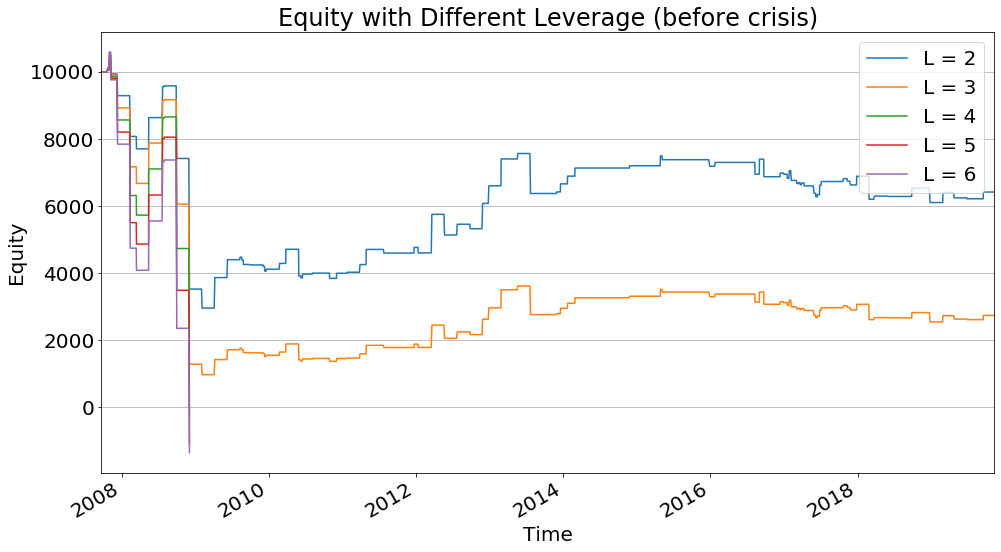

In [40]:
results_pre_crisis['Equity'].plot(label='L = 2')
results_pre_crisis_l3['Equity'].plot(label='L = 3')
results_pre_crisis_l4['Equity'].plot(label='L = 4')
results_pre_crisis_l5['Equity'].plot(label='L = 5')
results_pre_crisis_l6['Equity'].plot(label='L = 6')
plt.grid(True, axis='y')
plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Equity')
plt.title('Equity with Different Leverage (before crisis)')
plt.savefig('Results/Real_Return_leverage_before_crisis.jpg')

In [41]:
sharpe_pre_crisis =  results_pre_crisis['Unreal_Return'].mean()/results_pre_crisis['Unreal_Return'].std()
sharpe_pre_crisis_l3 =  results_pre_crisis_l3['Unreal_Return'].mean()/results_pre_crisis_l3['Unreal_Return'].std()
sharpe_pre_crisis_l4 =  results_pre_crisis_l4['Unreal_Return'].mean()/results_pre_crisis_l4['Unreal_Return'].std()
sharpe_pre_crisis_l5 =  results_pre_crisis_l5['Unreal_Return'].mean()/results_pre_crisis_l5['Unreal_Return'].std()
sharpe_pre_crisis_l6 =  results_pre_crisis_l6['Unreal_Return'].mean()/results_pre_crisis_l6['Unreal_Return'].std()


print('L2, Sharpe Ratio each year:', sharpe_pre_crisis * np.sqrt(251))
print('L3, Sharpe Ratio each year:', sharpe_pre_crisis_l3 * np.sqrt(251))
print('L4, Sharpe Ratio each year:', sharpe_pre_crisis_l4 * np.sqrt(251))
print('L5, Sharpe Ratio each year:', sharpe_pre_crisis_l5 * np.sqrt(251))
print('L6, Sharpe Ratio each year:', sharpe_pre_crisis_l6 * np.sqrt(251))

L2, Sharpe Ratio each year: 0.18768580353692282
L3, Sharpe Ratio each year: 0.17116406192954942
L4, Sharpe Ratio each year: -5.840165927156961
L5, Sharpe Ratio each year: -5.852224515308024
L6, Sharpe Ratio each year: -5.860262097416548
